In [1]:
from sklearn.linear_model import LogisticRegression

import pandas as pd
import numpy as np
import vset, bounds
import matplotlib.pyplot as plt

from dgp import *
import estimation, utils, experiments, plots

In [151]:
df = pd.read_csv('data/obermeyer.csv')
screen_out = df[df['program_enrolled_t'] == 0].iloc[:1000]
screen_in = df[df['program_enrolled_t'] == 1]
df = pd.concat([screen_in, screen_out])


In [166]:
df = pd.read_csv('data/obermeyer.csv')
screen_out = df[df['program_enrolled_t'] == 0].iloc[:1000]
screen_in = df[df['program_enrolled_t'] == 1]
df = pd.concat([screen_in, screen_out])

data = {}
feats = [i for i in df.columns.tolist() if 'tm1' in i]

data['Y'] = (df['gagne_sum_t'] > 0).astype(int).to_numpy()
data['D'] = df['program_enrolled_t'].to_numpy()
data['T'] = (df['cost_t'] > 2000).to_numpy()
data['XU'] = df[feats].to_numpy()

dgp = {}
nuisance_probs = []
u = np.array([[1,0], [0, 1]])
Vpf_down, Vpf_up = vset.compute_na_bounds(dgp, data, nuisance_probs)

D, T, Y = data['D'], data['T'], data['Y']
v = np.zeros((2,2,2))

for y in range(2):
    for d in range(2):
        for t in range(2):
            v[y,t,d] = ((Y==y) & (D==d) & (T==t)).mean()

Rs_down, Rs_up = bounds.standard_bounds(v, Vpf_down, Vpf_up, u, 'm_a=0')
Rd_down, Rd_up = bounds.delta_bounds(v, Vpf_down, Vpf_up, u, 'm_a=0')

In [167]:

Rs_down, Rs_up

(-0.986004338394794, 0.9211740911062907)

In [168]:
Rd_down, Rd_up

(-0.5681540130151843, 0.5030780911062906)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


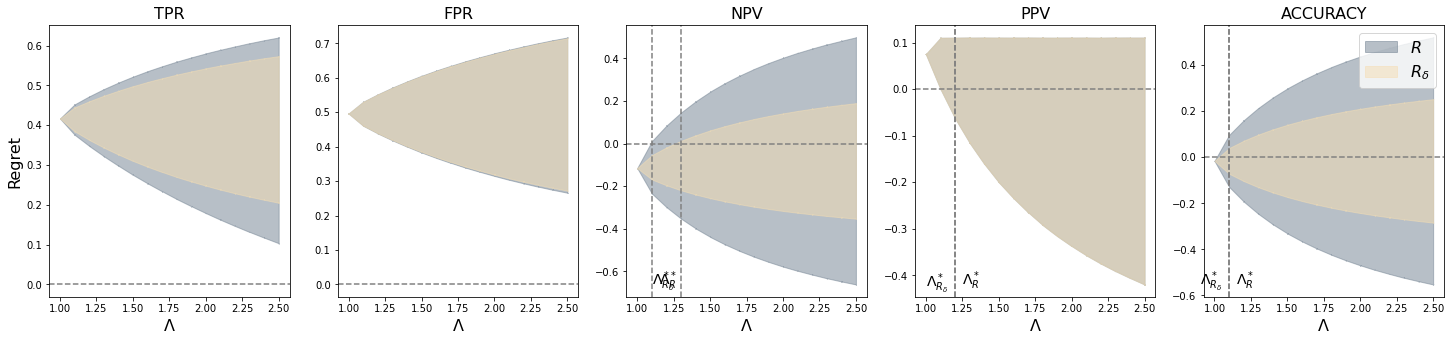

In [6]:
def get_screening_dgp(fname, n_screen_out):

    df = pd.read_csv(fname)
    screen_in = df[df['program_enrolled_t'] == 1]
    screen_out = df[df['program_enrolled_t'] == 0].iloc[:n_screen_out]
    df = pd.concat([screen_in, screen_out])

    feats = [i for i in df.columns.tolist() if 'tm1' in i]
    data = {}
    data['Y'] = (df['gagne_sum_t'] > 0).astype(int).to_numpy()
    data['D'] = df['program_enrolled_t'].to_numpy()
    data['XU'] = df[feats].to_numpy()
    data['Z'] = np.ones_like(df['cost_t'])
    
    # TODO: construct different T's
    data['T'] = (df['cost_t'] > 3000).to_numpy()
    
    return data

Dx, Du = 5, 0
nD = Dx+Du

dgp = {
    'N': 10000,
    'Dx': Dx,
    'Du': Du,
    'nz': 10,                # Number of finite pre-treatment values
    'beta_zy': 0,            # Z -> Y loading (=0 ==> exclusion restriction is satisfied)
    'e1_coeffs': 4*np.random.rand(nD) - 2,
    'z_coeffs':  4*np.random.rand(nD) - 2,
    'mu1_coeffs': 4*np.random.rand(nD) - 1,
    'mu0_coeffs': 4*np.random.rand(nD) - 2,
    'lambda': 2
}

dgp = set_dgp_config(dgp, 'MSM')
lambdas = np.arange(1, 2.6, .1)
data = get_screening_dgp(fname='data/obermeyer.csv', n_screen_out=3000)
estimation.sample_split_crossfit(dgp, data, id_method='MSM', est_method='plugin', K=5)
brdf = experiments.design_sensitivity_exp(dgp, data, lambdas, n_sims=10)
plots.plot_design_sensitivity(brdf)
